<a href="https://colab.research.google.com/github/miiiingi/dacon_housing/blob/main/dacon_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive/')
my_folder = '/gdrive/MyDrive/ColabNotebooks/dacon_housing/housing'

Mounted at /gdrive/


In [439]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [471]:
trainset = pd.read_csv(f'{my_folder}/train.csv')
trainset = trainset.drop('id', axis = 1)

testset = pd.read_csv(f'{my_folder}/test.csv')
testset = testset.drop('id', axis = 1)

col_numerical = list(set(trainset.describe().columns))
col_categorical = list((set(trainset.columns) - set(col_numerical)))

타겟 변수의 분포를 보니 거의 정규분포로 봐도 무방할 정도의 왜도와 첨도를 가지고 있다.

In [472]:
print(col_numerical)

['Overall Qual', 'Garage Yr Blt', 'Garage Cars', 'Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'target', 'Garage Area', '1st Flr SF', 'Full Bath', 'Year Remod/Add']


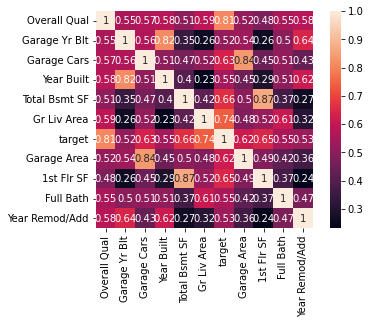

In [473]:
trainset_numerical = pd.DataFrame()
for col in col_numerical : 
  trainset_numerical[col] = trainset[col]
scaler = StandardScaler()
trainset_numerical_corr = pd.DataFrame(scaler.fit_transform(trainset_numerical), columns = col_numerical).corr()
sns.heatmap(trainset_numerical_corr, square = True, annot = True)

Garage Area(차고 면적) : Garage Cars(차고 자리 개수), target과 높은 상관관계 \\
1st Flr SF(1층 면적) : Total Bstm SF(지하실 면적), target과 높은 상관관계 \\
Garage Yr Blt(차고 완공 연도) : Year Remod Add(리모델링 연도), Year Built(완공 연도) \\
Full Bath(지상층 화장실 갯수) : Gr Liv Area(지상층 생활 면적), target과 높은 상관관계 \\
Gr Liv Area(지상층 생활 면적) : Full Bath, target과 높은 상관관계 \\
Overall Qual(전반적인 품질) : target과 높은 상관관계 \\
target : Garage Area, 1st Flr SF, Garage Cars, Gr Liv Area, Overall Qual, Total Bsmt SF와 높은 상관관계

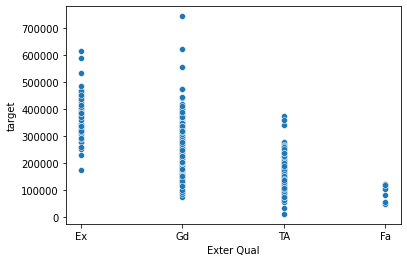

In [474]:
sns.scatterplot(data = trainset, x ='Exter Qual', y = 'target')

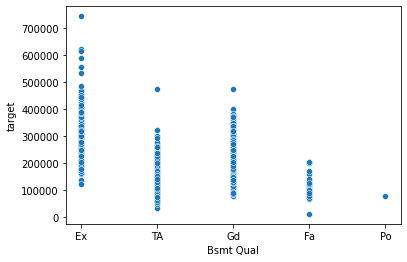

In [475]:
sns.scatterplot(data = trainset, x ='Bsmt Qual', y = 'target')

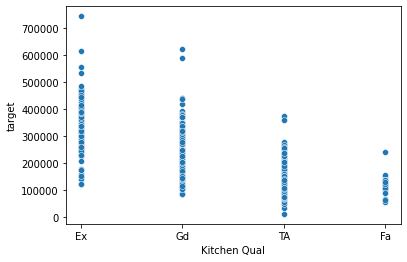

In [476]:
sns.scatterplot(data = trainset, x ='Kitchen Qual', y = 'target')

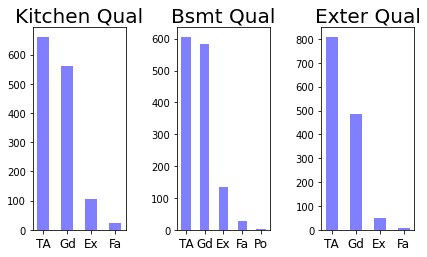

In [477]:
for i in range(len(col_categorical)):
    plt.subplot(1,3,i+1)
    plt.title(col_categorical[i], fontsize=20)
    temp = trainset[col_categorical[i]].value_counts()
    plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
    plt.xticks(temp.keys(), fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

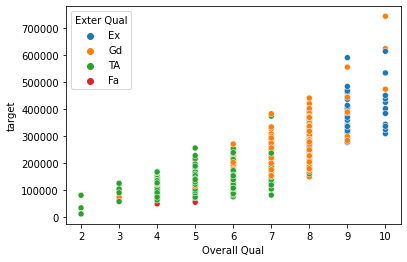

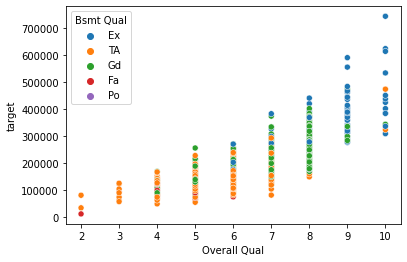

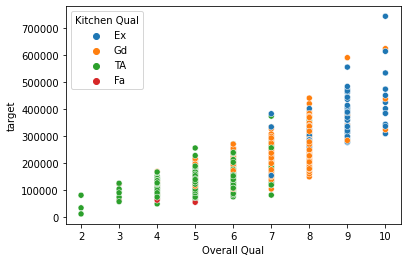

In [478]:
sns.scatterplot(data = trainset, x = 'Overall Qual', y = 'target', hue = 'Exter Qual')
plt.show()
sns.scatterplot(data = trainset, x = 'Overall Qual', y = 'target', hue = 'Bsmt Qual')
plt.show()
sns.scatterplot(data = trainset, x = 'Overall Qual', y = 'target', hue = 'Kitchen Qual')
plt.show()

Bsmt 변수 없앤 것보다 없애지 않은 게 더 성능이 좋음 \\
Kitchen 변수 없앤 것보다 없애지 않은 게 더 성능이 좋음 >> 테스트셋의 Kitchen qual을 살리면 더 성능이 좋을 듯..? >> 살려서 좋은 등급하고 좋지 않은 등급으로 나누니까 더 성능이 올라감 \\
Exter Qual은 나누지 않는 게 더 좋을 듯..?


In [479]:
trainset.loc[trainset['Kitchen Qual'] == 'Gd', 'Kitchen Qual'] = 'Ex'
trainset.loc[(trainset['Kitchen Qual'] == 'TA') | (trainset['Kitchen Qual'] == 'Fa') | (trainset['Kitchen Qual'] == 'Po'), 'Kitchen Qual'] = 'TA'

결측치 확인하기 > 결측치가 존재하지 않음 \\
수치 > 평균 0 표준편차 1로 정규화 \\
범주형 > 원핫인코딩

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


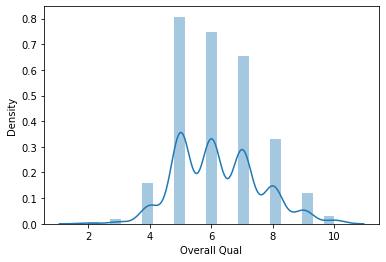

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


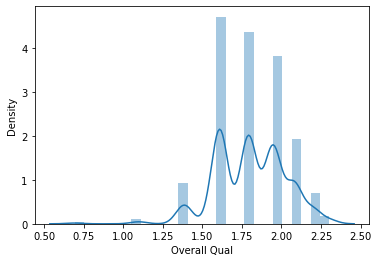

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


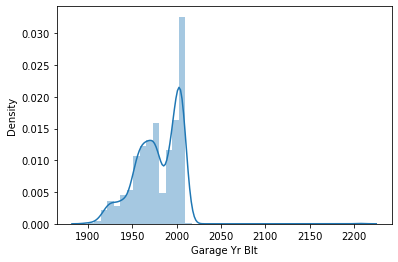

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


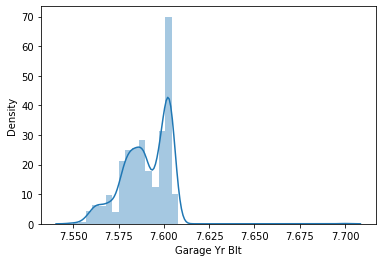

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


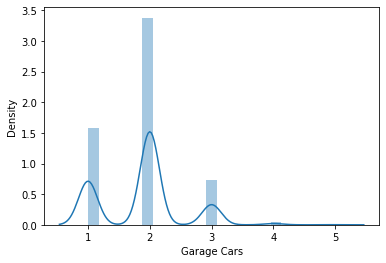

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


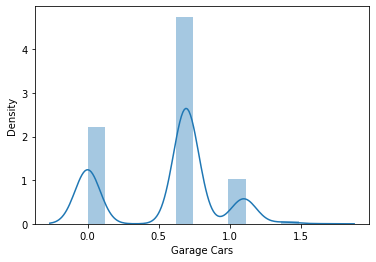

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


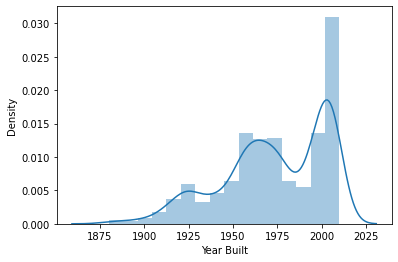

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


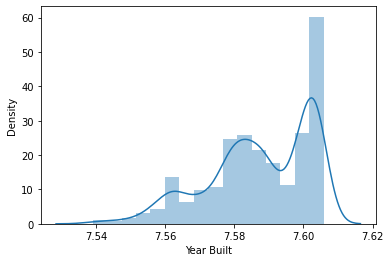

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


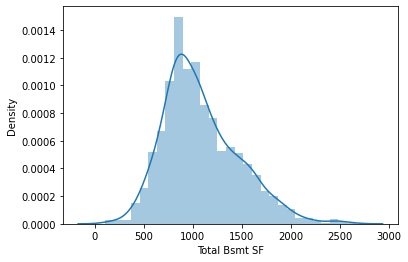

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


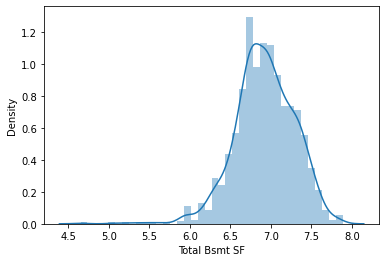

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


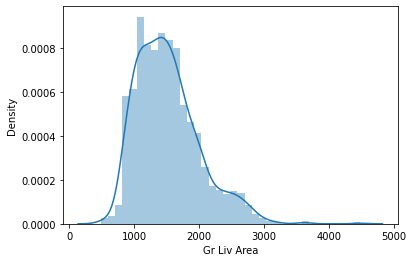

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


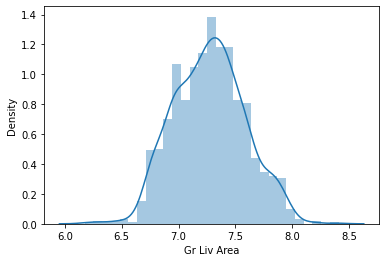

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


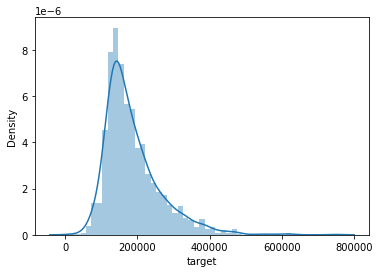

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


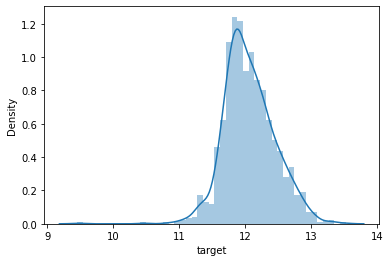

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


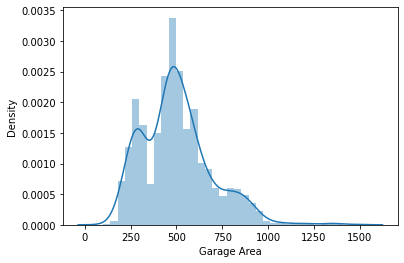

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


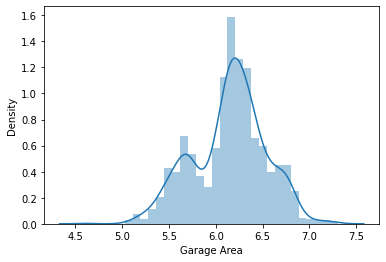

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


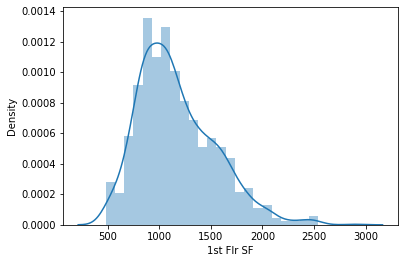

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


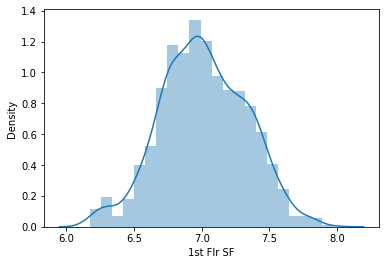

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


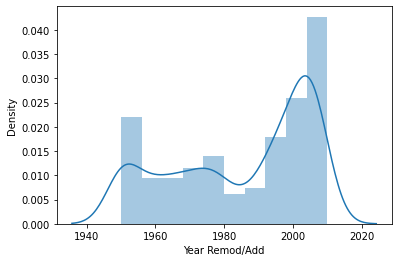

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


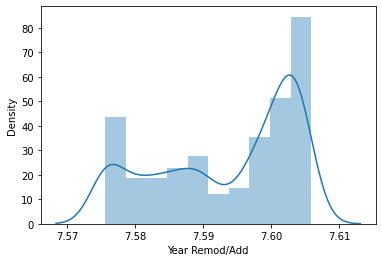

In [480]:
for col in col_numerical :
  if col == 'Full Bath' :
    continue
  sns.distplot(trainset[col])
  plt.show()
  sns.distplot(trainset[col].apply(np.log))
  plt.show()

In [481]:
for col in col_numerical : 
  if sum(trainset[col].isnull()) > 0 :
    print(f'{col} have a null values')
  if col == 'target' : 
    trainset[f'log_{col}'] = trainset[col].apply(np.log)
  num_mean = np.mean(trainset[col])
  num_std = np.std(trainset[col])
  trainset[col] = (trainset[col] - num_mean) / num_std

우선 성능이 어느정도 나오는지 체크해보기 위해 제출해보기

In [482]:
def NMAE(true, pred):
    true = np.exp(true)
    pred = np.exp(pred)
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [483]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn import svm
import lightgbm as lgbm
import xgboost as xgb
trainset = pd.get_dummies(trainset)
trainset = trainset.drop('target', axis = 1)
target_train = trainset['log_target']
data_train = trainset.drop('log_target', axis = 1)

scorer = make_scorer(NMAE)
reg = LinearRegression()
reg_rf = RandomForestRegressor()
reg_lgbm = lgbm.LGBMRegressor()
reg_xgb = xgb.XGBRegressor()
reg_knn = KNeighborsRegressor()
reg_svr = svm.SVR()
reg_extratree = ExtraTreesRegressor()
reg.fit(data_train, target_train)
reg_rf.fit(data_train, target_train)
reg_lgbm.fit(data_train, target_train)
reg_xgb.fit(data_train, target_train)
reg_knn.fit(data_train, target_train)
reg_svr.fit(data_train, target_train)
reg_extratree.fit(data_train, target_train)

reg_ensemble = VotingRegressor([('linear', reg), ('rf', reg_rf), ('lgbm', reg_lgbm), ('xgb', reg_xgb), ('knn', reg_knn), ('svr', reg_svr), ('extratree', reg_extratree)])
reg_ensemble.fit(data_train, target_train)

[08:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('rf', RandomForestRegressor()),
                            ('lgbm', LGBMRegressor()), ('xgb', XGBRegressor()),
                            ('knn', KNeighborsRegressor()), ('svr', SVR()),
                            ('extratree', ExtraTreesRegressor())])

In [485]:
print(f' reg : {np.mean(cross_val_score(reg, data_train, target_train, cv = 2, scoring= scorer))}')
print(f' rf : {np.mean(cross_val_score(reg_rf, data_train, target_train, cv = 2, scoring= scorer))}')
print(f' lgbm : {np.mean(cross_val_score(reg_lgbm, data_train, target_train, cv = 2, scoring= scorer))}')
print(f' xgb : {np.mean(cross_val_score(reg_xgb, data_train, target_train, cv = 2, scoring= scorer))}')
print(f' knn : {np.mean(cross_val_score(reg_knn, data_train, target_train, cv = 2, scoring= scorer))}')
print(f' svr : {np.mean(cross_val_score(reg_svr, data_train, target_train, cv = 2, scoring= scorer))}')
print(f' extratree : {np.mean(cross_val_score(reg_extratree, data_train, target_train, cv = 2, scoring= scorer))}')
print(f' ens : {np.mean(cross_val_score(reg_ensemble, data_train, target_train, cv = 2, scoring= scorer))}')

 reg : 0.09851620359139016
 rf : 0.10206752921343462
 lgbm : 0.10489930169317127
[08:22:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 xgb : 0.1011543633194199
 knn : 0.11324917343929711
 svr : 0.10386500906511076
 extratree : 0.10335822628942087
[08:22:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 ens : 0.09573598169977507


변수 log o 0.09726779249178891 \\
변수 log x 0.09705621953331948 \\
타겟 log o 0.09611565911802278 \\
변수 정규화 x 0.09598049273647105 \\
변수 정규화 o 0.0959481850360516 \\
변수 이상치 없애기 z >= 3 0.09153602059131043 \\
변수 이상치 없애기 z >= 4 0.09574051433635702 \\
변수 이상치 없애기 z >= 5 0.09426153093876602

In [486]:
col_numerical.remove('target')

In [487]:
testset.loc[testset['Kitchen Qual'] == 'Gd', 'Kitchen Qual'] = 'Ex'
testset.loc[(testset['Kitchen Qual'] == 'TA') | (testset['Kitchen Qual'] == 'Fa') | (testset['Kitchen Qual'] == 'Po'), 'Kitchen Qual'] = 'TA'

In [488]:
for col in col_numerical : 
  if sum(testset[col].isnull()) > 0 :
    print(f'{col} have a null values')
  num_mean = np.mean(testset[col])
  num_std = np.std(testset[col])
  testset[col] = (testset[col] - num_mean) / num_std
testset = pd.get_dummies(testset)

In [489]:
print(testset.columns)

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt', 'Exter Qual_Ex', 'Exter Qual_Fa',
       'Exter Qual_Gd', 'Exter Qual_TA', 'Kitchen Qual_Ex', 'Kitchen Qual_TA',
       'Bsmt Qual_Ex', 'Bsmt Qual_Fa', 'Bsmt Qual_Gd', 'Bsmt Qual_Po',
       'Bsmt Qual_TA'],
      dtype='object')


In [492]:
prediction = np.exp(reg_ensemble.predict(testset))
print(prediction)
sample_submission = pd.read_csv(f'{my_folder}/sample_submission.csv')
answer = pd.DataFrame({'id' : sample_submission['id'], 'target' : prediction})
answer.to_csv(f"{my_folder}/submission.csv", index=False)

[320021.37639735 126993.71141724 176223.7509479  ...  81824.83948196
 189873.79518389 135837.78677993]


0.1116 > 0.1131 \\
0.09770789431479524 > 0.09762 \\
0.09716450927941744 > 0.09717 \\
0.09595506714003371 >0.09644 \\
0.09597481482516101 > 0.0966606798 \\
0.09573598169977507 > 0.094391833